<a href="https://colab.research.google.com/github/jakubhorvath/VariousMLNotebooks/blob/main/TF_IDF_EmotionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Edit Acronyms to full-length words

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the acronyms list
acronyms_dict = {}
with open("/content/drive/MyDrive/SentimentAnalysis/acronyms.txt") as acronyms_file:
  lines = acronyms_file.readlines()
  lines = [line for line in lines if line != '\n']
  acronyms = [lines[i*2][:-1] for i in range(0, len(lines)//2)]
  meanings = [lines[i*2+1][:-1] for i in range(0, len(lines)//2)]
  for acronym, meaning in zip(acronyms, meanings):
    if acronym in acronyms_dict:
      acronyms_dict[acronym].append(meaning)
    else:
      acronyms_dict[acronym] = [meaning]

# print acronyms with multiple meanings and choose the one that makes the most sense
for key in acronyms_dict:
  if len(acronyms_dict[key]) > 1:
    ms = acronyms_dict[key]


# select the ones that make sense
acronyms_dict["BRB"] = ["Be right back"]
acronyms_dict["CC"] = ["Carbon copy"]
acronyms_dict["DL"] = ["Down low"]
acronyms_dict["ETA"] = ["Estimated time of arrival"]
acronyms_dict["GF"] = ["Girlfriend"]
acronyms_dict["GG"] = ["Good game"]
acronyms_dict["GL"] = ["Good luck"]
acronyms_dict["HOAS"] = ["Hold on a second"]
acronyms_dict["HW"] = ["Homework"]
acronyms_dict["IC"] = ["I see"]
acronyms_dict["IM"] = ["Instant message"]
acronyms_dict["K"] = ["OK"]
acronyms_dict["LOL"] = ["Laughing out loud"]
acronyms_dict["N/A"] = ["Not Available"]
acronyms_dict["NC"] = ["No comment"]
acronyms_dict["NM"] = ["Not much"]
acronyms_dict["NVM"] = ["Nevermind"]
acronyms_dict["NC"] = ["No comment"]
acronyms_dict["OT"] = ["Off topic"]
acronyms_dict["PM"] = ["Private message"]
acronyms_dict["POS"] = ["Piece of shit"]
acronyms_dict["RE"] = ["Regarding"]
acronyms_dict["ROFL"] = ["Rolling on the floor laughing"]
acronyms_dict["SOS"] = ["Save our souls"]
acronyms_dict["TC"] = ["Take care"]
acronyms_dict["UR"] = ["Your"]
acronyms_dict["WB"] = ["Welcome back"]
acronyms_dict["Y"] = ["Why"]

keys = acronyms_dict.keys()
values = acronyms_dict.values()
acronyms_dict = {}

for key, value in zip(keys, values):
  acronyms_dict[key.lower()] = value[0].lower()

In [ ]:
import re
def replace_acronym(text, acronyms_dict):
  for acronym in acronyms_dict:
    text = re.sub(f" {acronym} ", acronyms_dict[acronym][0], text)
  return text

## Preprocess, remove hyperlinks, turn to lowercase

In [ ]:
import pandas as pd

with open("/content/drive/MyDrive/SentimentAnalysis/Corpus_Reddit.txt") as reddit_posts:
  lines = [line[:-1] for line in reddit_posts.readlines()]
data = pd.DataFrame({"text": lines})

# So far working with only 1000 texts
#data = data[:10]


# in many places â€™ occurs in place of ' so replace these
data["text"] = data["text"].apply(lambda x: x.replace("â€™", "\'"))

# remove links
data["text"] = data["text"].apply(lambda x: re.sub("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", '', x))

# turn all letters to lowercase
data["text"] = data["text"].apply(lambda x: x.lower())

# remove all occurences of "'* " (e.g. 's, 'm, 're)
# TODO

# replace acronyms
data["text"] = data["text"].apply(lambda x: replace_acronym(x, acronyms_dict))

# remove characters that are not letters
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]',' ',x)))




## Tokenize the text

In [ ]:
def get_full_words(text):
  # tokenize
  result = text.split()

  #remove short words
  result = [x for x in result if len(x) > 2]

  return result

tokenized = list(data["text"].apply(lambda x: get_full_words(x)))



In [ ]:
!pip install pyplutchik

In [ ]:
from pyplutchik import plutchik

class WordObject:
  """
  Class for storing wordvectors
  value: the string value of the word
  emotions: array of emotional values for that word
  occurences: n of times that the word appears in the texts

  """
  def __init__(self, word):
    self.value = word
    self.emotions = np.zeros(5)
    self.occurences = 0

  def get_emotion_value(self, emotion):
    if emotion == "Happy":
      index = 0
    elif emotion == "Angry":
      index = 1
    elif emotion == "Surprise":
      index = 2
    elif emotion == "Fear":
      index = 3
    else:# emotion == "Sad":
      index = 4
    return self.emotions[index] / self.occurences

  def get_all_emotions(self):
    return self.emotions / self.occurences

  def modify_values(self, array):
    self.emotions += array
    self.occurences += 1

  def get_plutchik_graph(self):
    emotions = {"joy": self.emotions[0]/ self.occurences, "anger": self.emotions[1]/ self.occurences, "surprise": self.emotions[2]/ self.occurences,"fear": self.emotions[3]/ self.occurences, "sadness": self.emotions[4]/ self.occurences}
    plutchik(emotions)

class Dictionary:
  def __init__(self):
    self.words = {}

  def add_word(self, word, emotions):
    if word not in self.words:
      self.words[word] = WordObject(word)
    self.words[word].modify_values(emotions)

  def to_dict():
    pass


# We extend the emotions table by synonyms of words

In [ ]:
import requests
from bs4 import BeautifulSoup

# code obtained from https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api
def synonyms(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms

In [ ]:
import numpy as np
moods = pd.read_csv("/content/drive/MyDrive/SentimentAnalysis/MoodBook.csv")
moods = moods[["Fear", 	"Anger", 	"Sadness", 	"Joy", 	"Surprise", 	"Disgust", 	"Trust", 	"Anticipation"]]

In [ ]:
def extend_by_synonyms(emotion_words):
  word_set = set()
  for word in emotion_words:
    synonyms_list = synonyms(word)
    for synonym in synonyms_list:
      word_set.add(synonym)
    word_set.add(word)
  return list(word_set)


In [ ]:
moods_improved = pd.read_csv("/content/drive/MyDrive/SentimentAnalysis/MoodBook_improved.csv").iloc[: , 1:]
moods_improved

Fear             Anger  ...         Trust  Anticipation
0         NaN               NaN  ...  expectation   expectation 
1      demon            weaken   ...   groundwork            NaN
2     hassle           enraged   ...           NaN    recognize 
3         go           station   ...    recognize          show 
4     scared              blame  ...      backing         enjoy 
...       ...               ...  ...           ...           ...
2634      NaN  totalitarianism   ...           NaN           NaN
2635      NaN        ludicrous   ...           NaN           NaN
2636      NaN              lay   ...           NaN           NaN
2637      NaN  undistinguished   ...           NaN           NaN
2638      NaN              try   ...           NaN           NaN

[2639 rows x 8 columns]

In [ ]:
moods

Fear       Anger    Sadness  ...     Disgust      Trust  Anticipation
0     afraid     abusive     addict  ...      ashame     admire  anticipation
1      angst     abusing      alone  ...       annoy      agree      almighty
2    anxiety       abuse  ambulance  ...      biased      alive         Allah
3    careful      abduct   backdoor  ...    bullshit  apoligise         angel
4       dark  accusation        bad  ...  dispassion  apologize    appreciate
..       ...         ...        ...  ...         ...        ...           ...
582      NaN         NaN        NaN  ...         NaN        NaN           NaN
583      NaN         NaN        NaN  ...         NaN        NaN           NaN
584      NaN         NaN        NaN  ...         NaN        NaN           NaN
585      NaN         NaN        NaN  ...         NaN        NaN           NaN
586      NaN         NaN        NaN  ...         NaN        NaN           NaN

[587 rows x 8 columns]

In [ ]:
emotion_map = {}
emotion_to_index = {"Fear": 0, 	"Anger":1, 	"Sadness":2, 	"Joy":3, 	"Surprise":4, 	"Disgust":5, 	"Trust":6, 	"Anticipation":7}
word_counts = {}
# create the basic wordvectors
for emotion in moods_improved.columns:
  l  = list(moods_improved[emotion].dropna())
  print(emotion, len(l))
  for word in l:
    if word not in emotion_map:
      emotion_map[word] = np.zeros(len(moods_improved.columns)).astype(np.longdouble)
    emotion_map[word][emotion_to_index[emotion]] += 1

Fear 382
Anger 2638
Sadness 1463
Joy 1878
Surprise 233
Disgust 254
Trust 685
Anticipation 525


In [ ]:
def apply_moods(tokenized, emotion_map, emotion_to_index):
  new_words = {}
  line_emotions = []
  # for all the lines in the provided text
  for line in tokenized:
    emotion_sum = np.zeros(len(list(emotion_to_index.keys()))).astype(np.longdouble)
    word_set = set()
    # for all the words in each line
    for word in line:
      # if the word has a value in emotional_map and hasnt already been found
      if word in emotion_map and word not in word_set:
        # add it to the set of already processed words
        word_set.add(word)
        # increase that line's emotional value
        emotion_sum += emotion_map[word]
    # set the emotional values for that line
    line_emotions.append(emotion_sum)

  # for each line and its assigned emotions
  for emotions, line in zip(line_emotions, tokenized):

    word_set = set()
    # for each word in that line
    for word in line:
      # if its emotional value hasnt yet been increased
      if word not in word_set:
        word_set.add(word)
        # edit its emotional value or add new instance to the output dictionary
        if word in new_words:
          new_words[word] += emotions
        else:
          new_words[word] = np.zeros(len(list(emotion_to_index.keys()))).astype(np.longdouble) + emotions
  return new_words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_moods_with_TFIDF(tokenized, emotion_map, emotion_to_index, stop_words, df):

  # tokenize using tfidf
  t = []

  for line in tokenized:
    l = []
    for word in line:
      if word not in stop_words and word.isalpha():
        l.append(word)
    t.append(l)
  tokenized = t.copy()



  line_emotions = []
  # for all the lines in the provided text
  for line_index in range(len(tokenized)):
    emotion_sum = np.zeros(len(list(emotion_to_index.keys()))).astype(np.longdouble)
    word_set = set()
    # for all the words in each line
    for word in tokenized[line_index]:
      # if the word has a value in emotional_map and hasnt already been found
      if word in emotion_map and word not in word_set:
        # add it to the set of already processed words
        word_set.add(word)
        # increase that line's emotional value
        emotion_sum += emotion_map[word] * df[word][line_index]
    # set the emotional values for that line
    line_emotions.append(emotion_sum)

  new_words = {}
  line_index = 0
  # for each line and its assigned emotions
  for emotions, line in zip(line_emotions, tokenized):

    word_set = set()
    # for each word in that line
    for word in line:
      # if its emotional value hasnt yet been increased
      if word not in word_set:
        word_set.add(word)
        # edit its emotional value or add new instance to the output dictionary
        if word in new_words:
          new_words[word] += emotions
        else:
          new_words[word] = np.zeros(len(list(emotion_to_index.keys()))).astype(np.longdouble) + emotions
    line_index += 1
  return new_words

In [ ]:
new_words = apply_moods(tokenized[7700:14700], emotion_map, emotion_to_index)

In [ ]:
all_emotion_words = list(emotion_map.keys())
t = []
for line in tokenized[7700:]:
  l = []
  for word in line:
    if word in all_emotion_words:
      l.append(word)
  t.append(l)
t = [" ".join(line) for line in t]
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(t)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abuse  abusing  abusive  accidently  ...  wound  wow  wrong  yummy
0       0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
1       0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
2       0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
3       0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
4       0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
...     ...      ...      ...         ...  ...    ...  ...    ...    ...
9875    0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
9876    0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
9877    0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
9878    0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0
9879    0.0      0.0      0.0         0.0  ...    0.0  0.0    0.0    0.0

[9880 rows x 605 columns]

In [ ]:
new_words_tfidf = apply_moods_with_TFIDF(tokenized[7700:11200], emotion_map, emotion_to_index, stop_words, df)
new_words_tfidf2 = apply_moods_with_TFIDF(tokenized[11200:14700], emotion_map, emotion_to_index, stop_words, df)

In [ ]:
for word in new_words_tfidf2:
  if word in new_words_tfidf:
    new_words_tfidf[word] += new_words_tfidf2[word]
  else:
    new_words_tfidf[word] = new_words_tfidf2[word]


/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


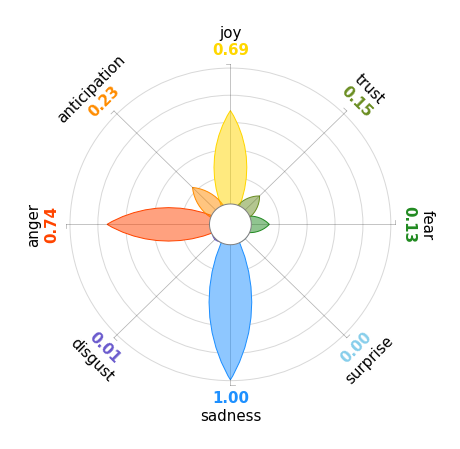

In [ ]:
x = new_words_tfidf["today"]
word = (x-min(x))/(max(x)-min(x)+1)

emotions = {"fear": word[0], 	"anger": word[1], 	"sadness":word[2], 	"joy":word[3], 	"surprise":word[4], 	"disgust":word[5], 	"trust":word[6], 	"anticipation":word[7]}
plutchik(emotions)

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


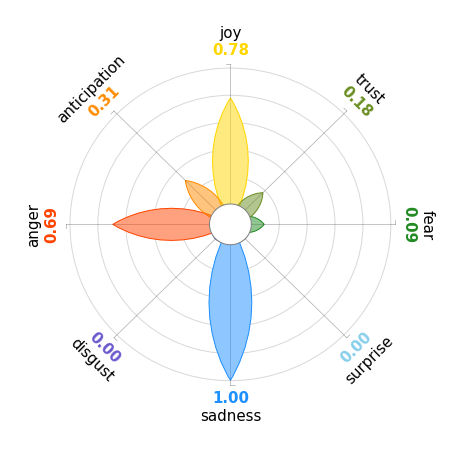

In [ ]:
x = new_words["today"]
word = (x-min(x))/(max(x)-min(x)+1)

emotions = {"fear": word[0], 	"anger": word[1], 	"sadness":word[2], 	"joy":word[3], 	"surprise":word[4], 	"disgust":word[5], 	"trust":word[6], 	"anticipation":word[7]}
plutchik(emotions)

In [ ]:
len(list(new_words_tfidf.keys()))

22960

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


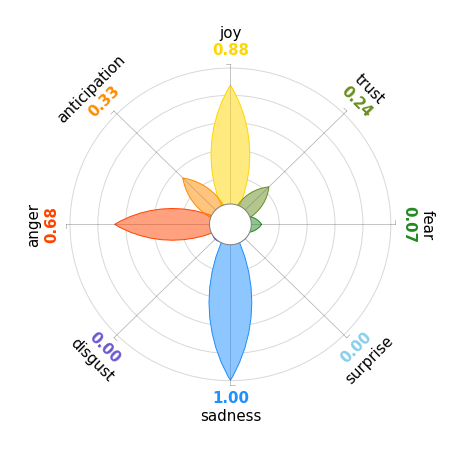

In [ ]:
new_words = apply_moods(tokenized, emotion_map, emotion_to_index)
x = new_words["phone"]
word = (x-min(x))/(max(x)-min(x)+1)

emotions = {"fear": word[0], 	"anger": word[1], 	"sadness":word[2], 	"joy":word[3], 	"surprise":word[4], 	"disgust":word[5], 	"trust":word[6], 	"anticipation":word[7]}
plutchik(emotions)

# Clustering

In [ ]:
words = list(new_words_tfidf.keys())
copies = new_words_tfidf.copy()
to_delete = []
for word in words:
  if sum(new_words_tfidf[word]) < 0.001:
    to_delete.append(word)

words = [word for word in words if word not in to_delete]

fear = [copies[word][0] for word in words]
anger = [copies[word][1] for word in words]
sadness = [copies[word][2] for word in words]
joy = [copies[word][3] for word in words]
surprise = [copies[word][4] for word in words]
disgust = [copies[word][5] for word in words]
trust = [copies[word][6] for word in words]
anticipation = [copies[word][7] for word in words]

words_df = pd.DataFrame({"Word": words,
                         "fear": fear,
                         "anger": anger,
                         "sadness":sadness,
                         "joy": joy,
                         "surprise":surprise,
                         "disgust":disgust,
                         "trust":trust,
                         "anticipation":anticipation})
words_df

Word       fear      anger  ...   disgust      trust  anticipation
0            fight   4.338668  22.014117  ...  1.217595   6.012258      7.231702
1          breathe  14.311284  68.160993  ...  8.495045  71.564318     20.897740
2            south   0.957948   5.275254  ...  0.218247   3.576206      1.619653
3            india   0.000000   0.696239  ...  0.000000   0.717810      0.358236
4         iataking   1.541473   6.851747  ...  0.224855   3.524615      3.142613
...            ...        ...        ...  ...       ...        ...           ...
18297     lengthen   0.000000   0.000000  ...  0.000000   0.000000      0.000000
18298       keepin   0.000000   0.000000  ...  0.000000   0.000000      0.000000
18299      fourish   0.000000   0.000000  ...  0.000000   0.000000      0.000000
18300  constrained   0.000000   0.000000  ...  0.000000   0.000000      0.000000
18301      hadtnew   0.000000   0.000000  ...  0.000000   0.000000      0.000000

[18302 rows x 9 columns]

In [ ]:
words_df.to_csv("/content/drive/MyDrive/SentimentAnalysis/emotional_dictionary.csv")

In [ ]:
words_df[words_df["Word"].str.contains("53a")]

Empty DataFrame
Columns: [Word, fear, anger, sadness, joy, surprise, disgust, trust, anticipation]
Index: []

In [ ]:
from collections import Counter
out_list = []
for line in tokenized:
  l = [word for word in line if word.isalpha() and word not in stop_words]
  out_list += l
counted = Counter(out_list)
sorted_tuples = sorted(counted.items(), key=lambda item: item[1])
sorted_dict = {k: v for k, v in sorted_tuples}
#k = {k: v for k, v in sorted(counted.items(), key=lambda item: item[1])}


/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/pyplutchik/pyplutchik.py:1240: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (8, 8))


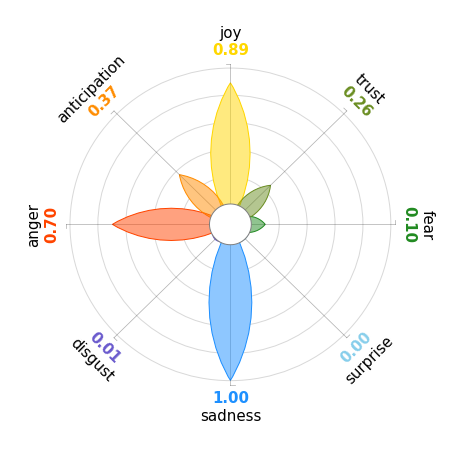

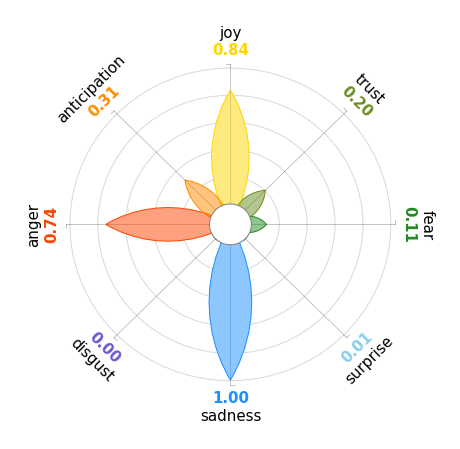

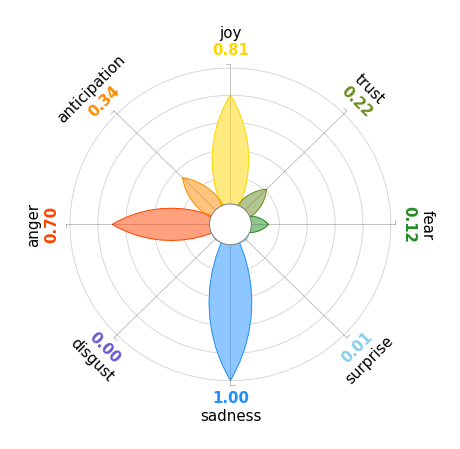

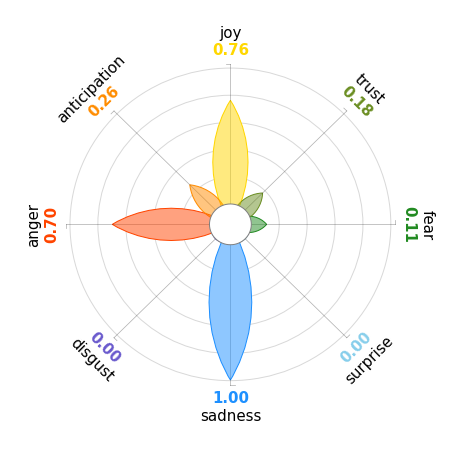

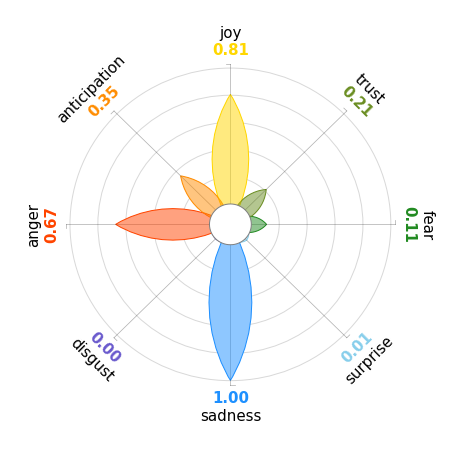

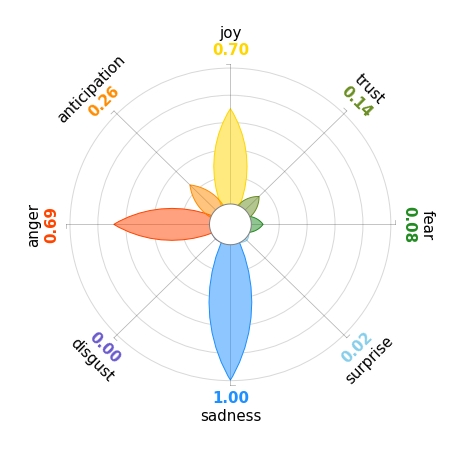

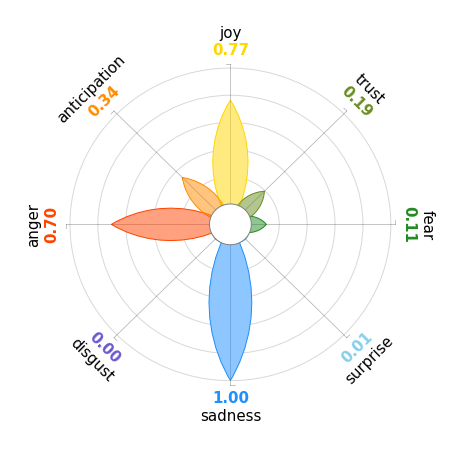

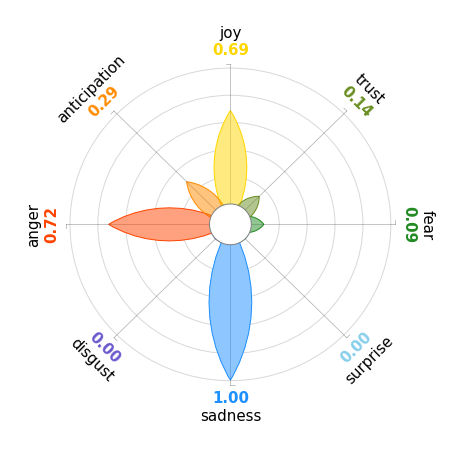

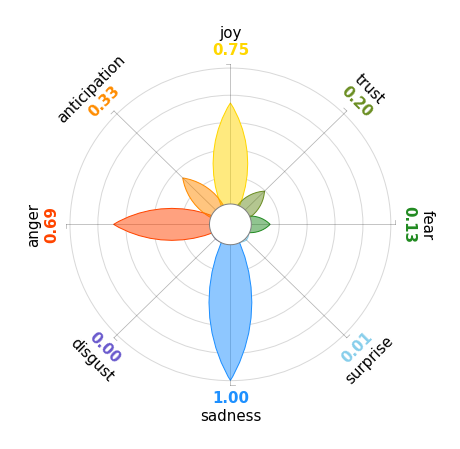

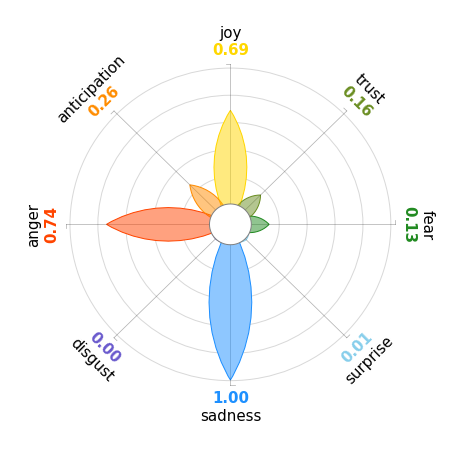

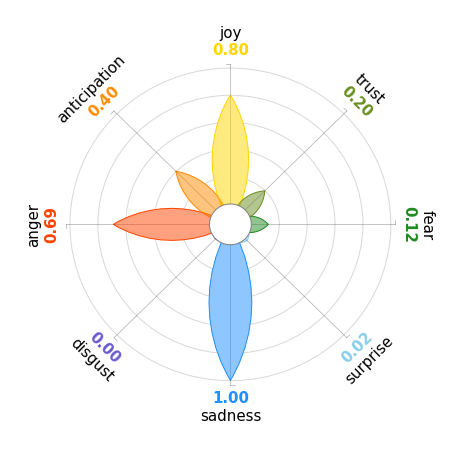

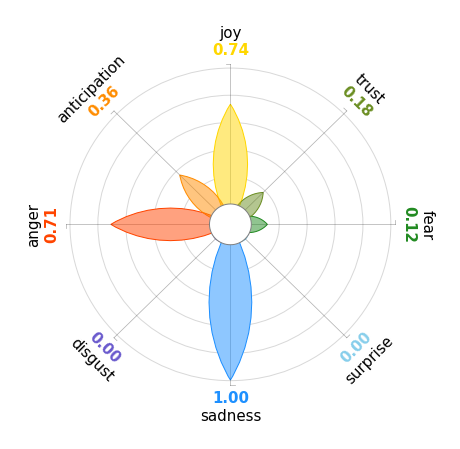

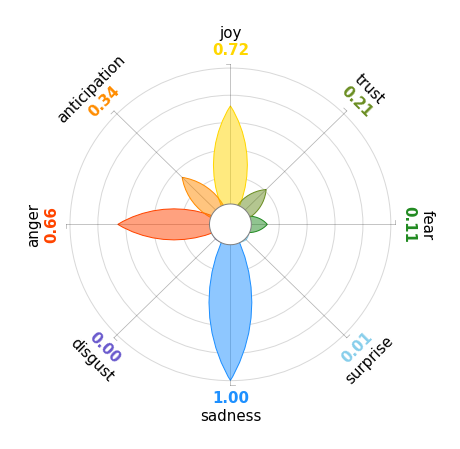

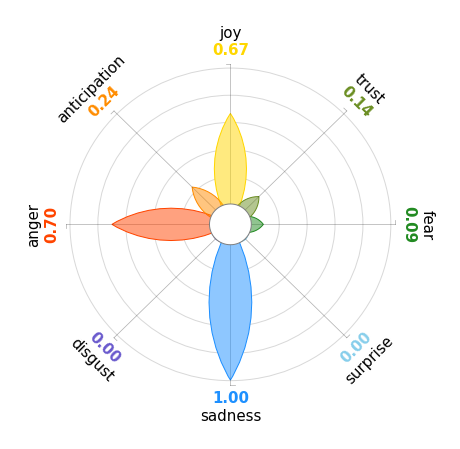

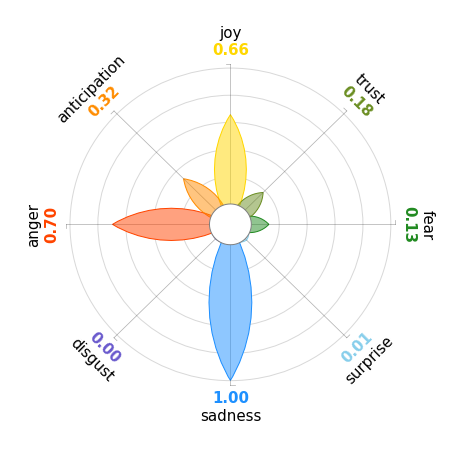

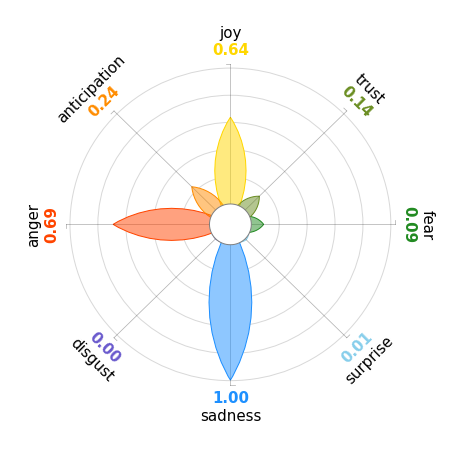

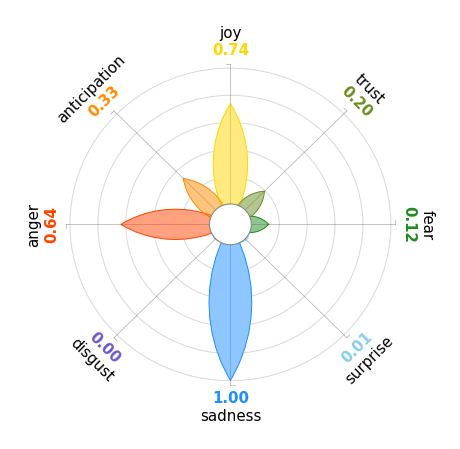

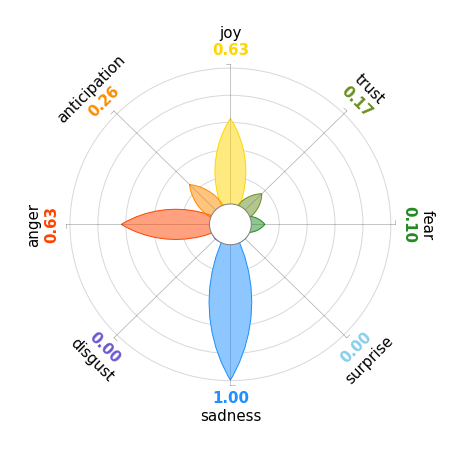

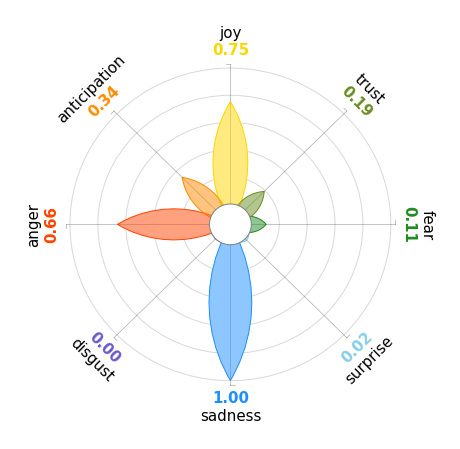

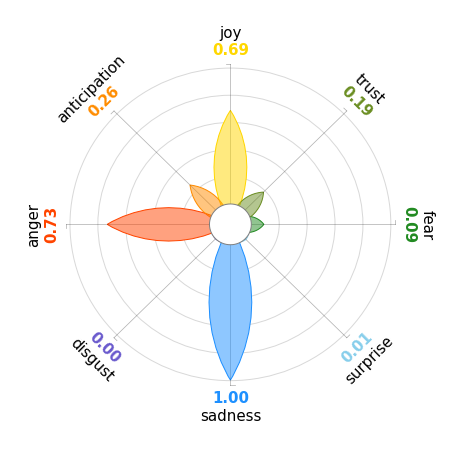

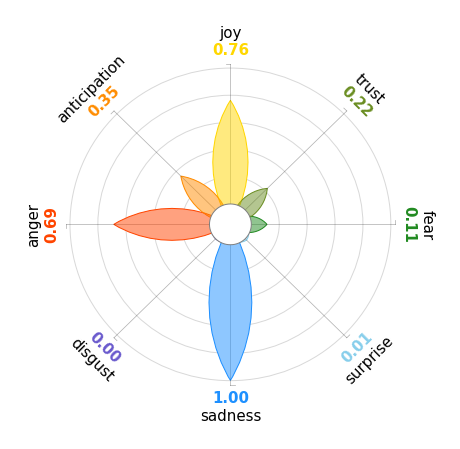

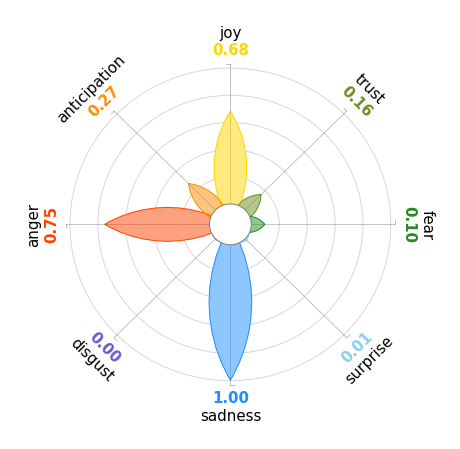

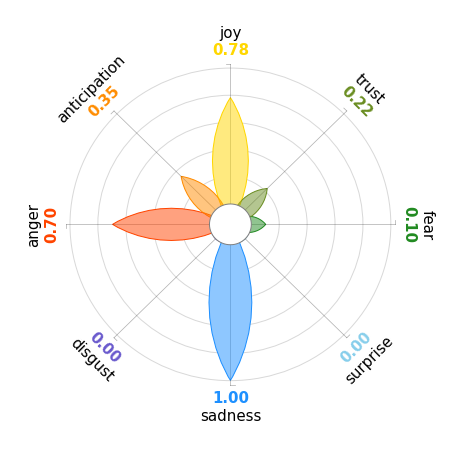

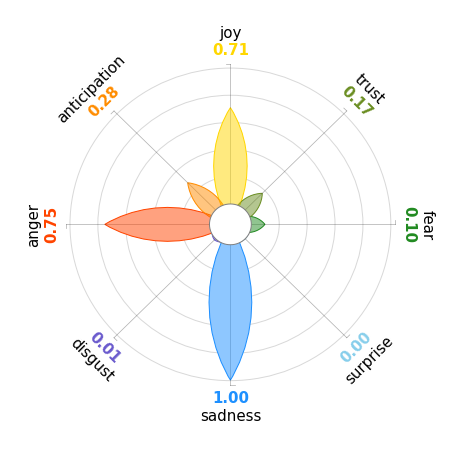

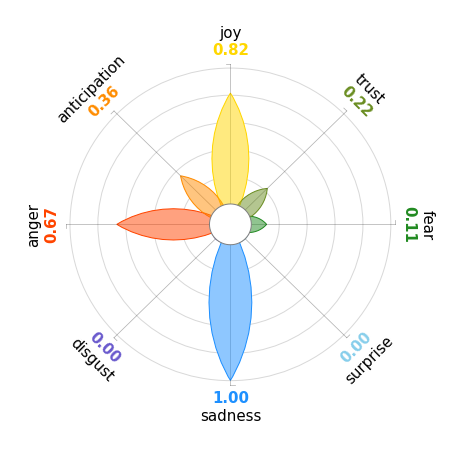

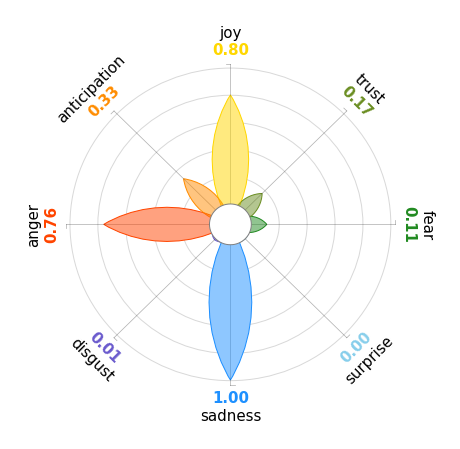

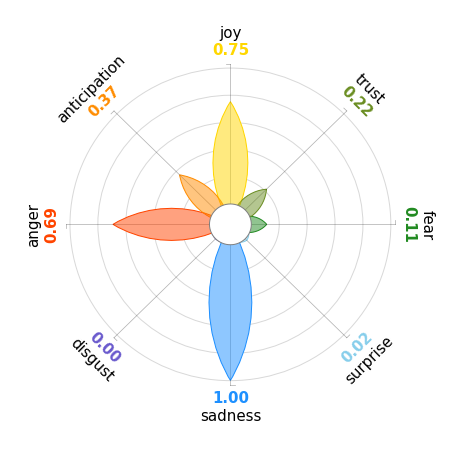

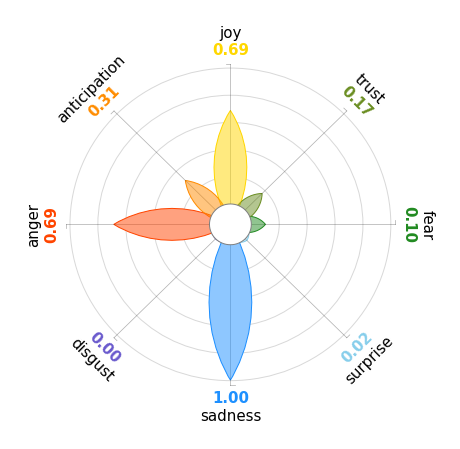

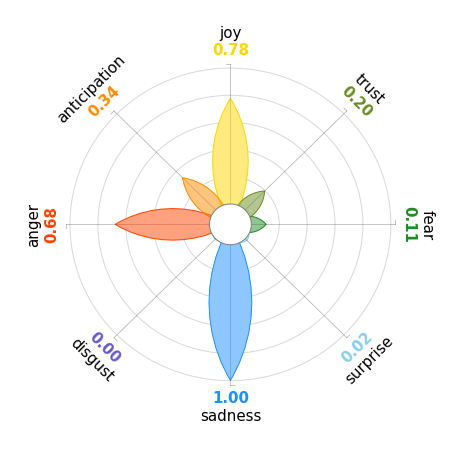

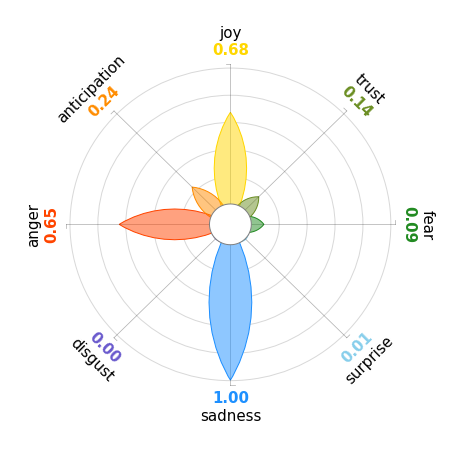

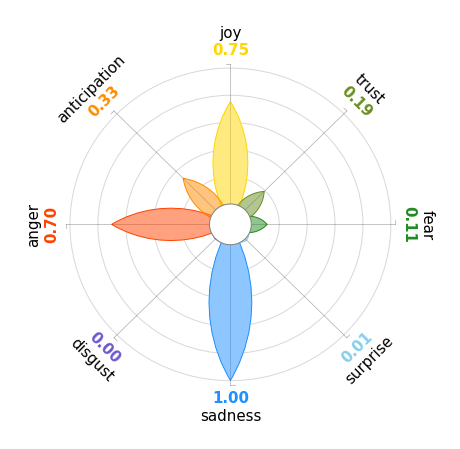

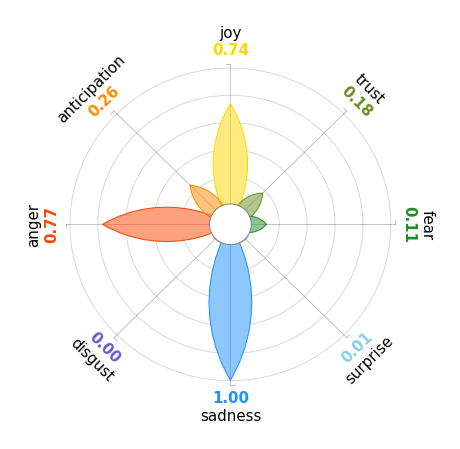

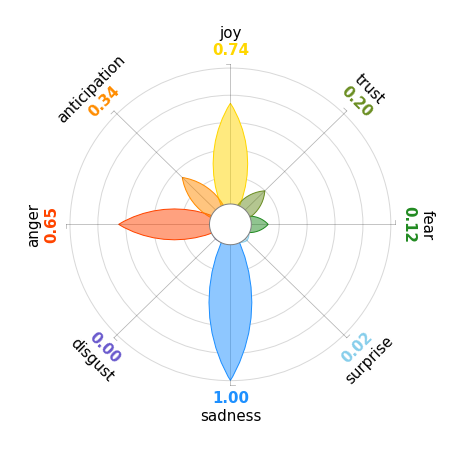

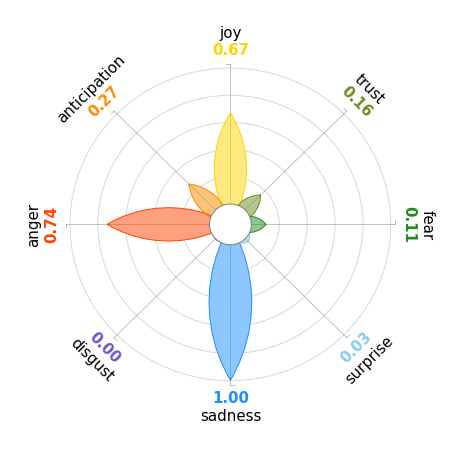

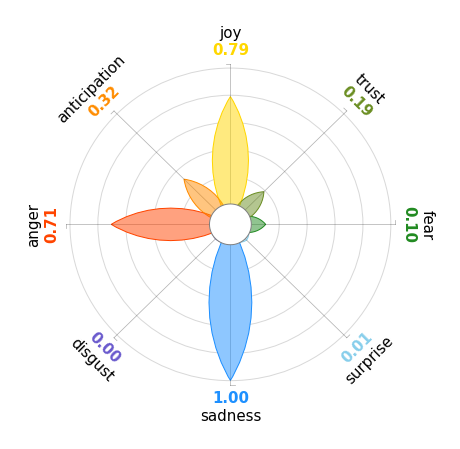

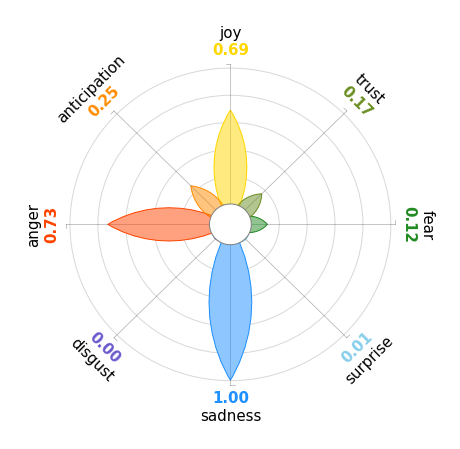

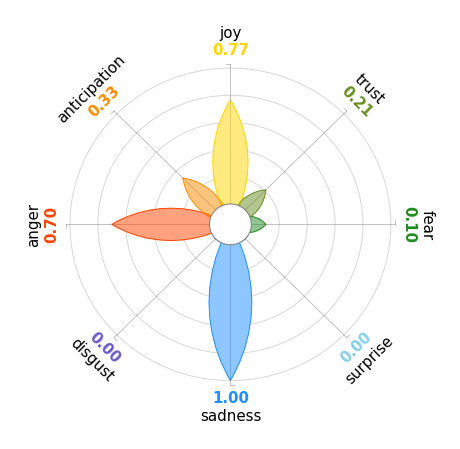

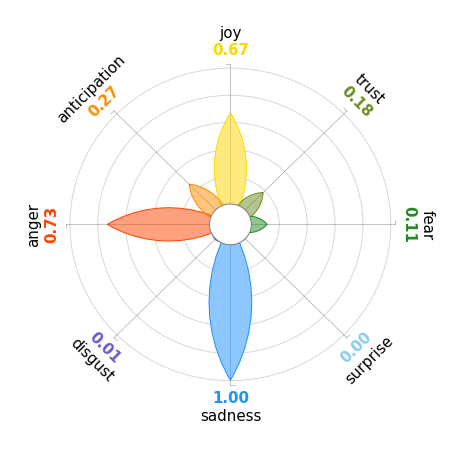

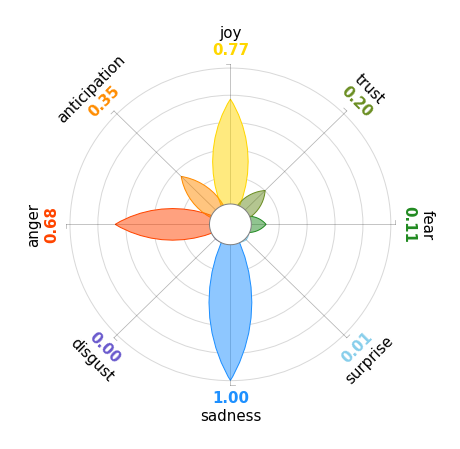

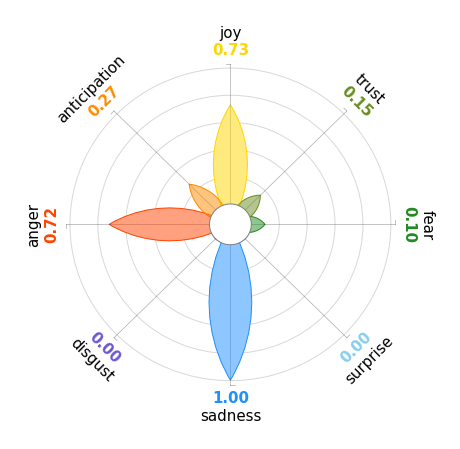

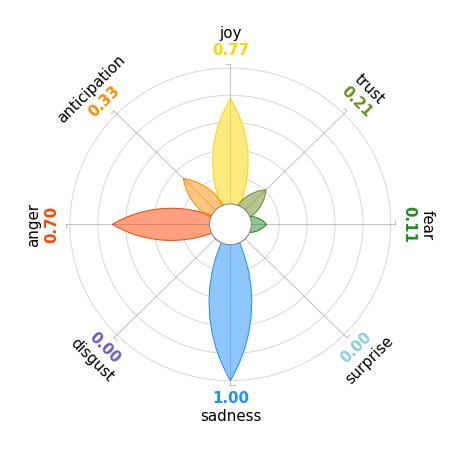

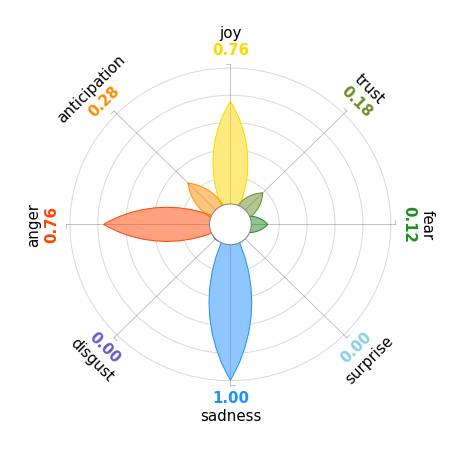

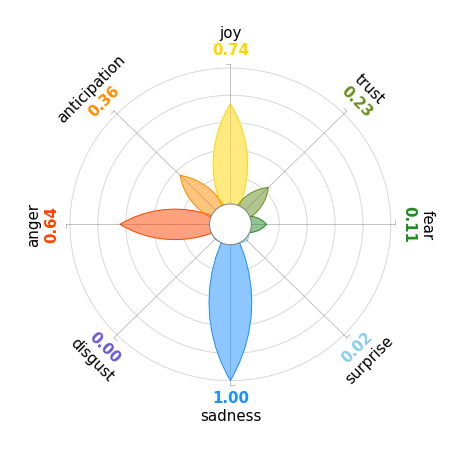

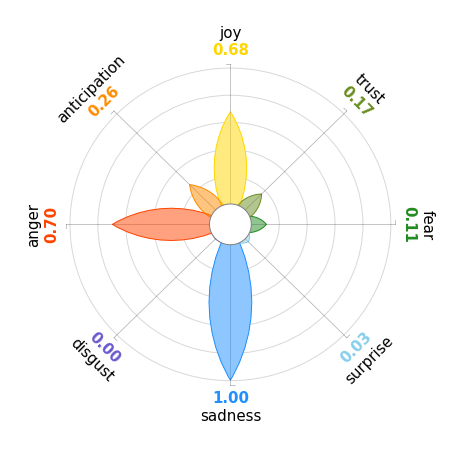

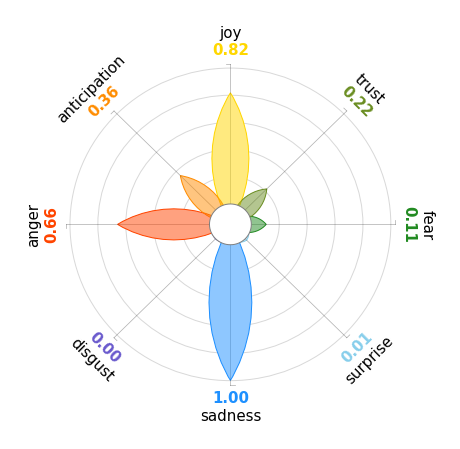

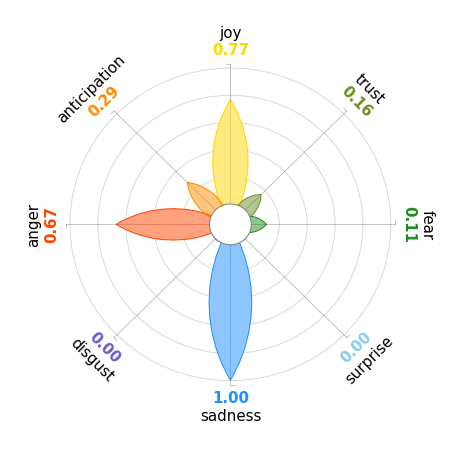

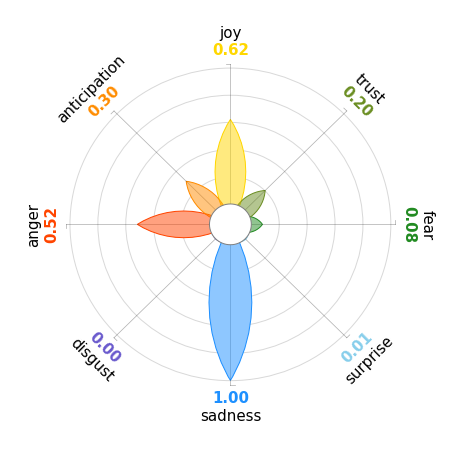

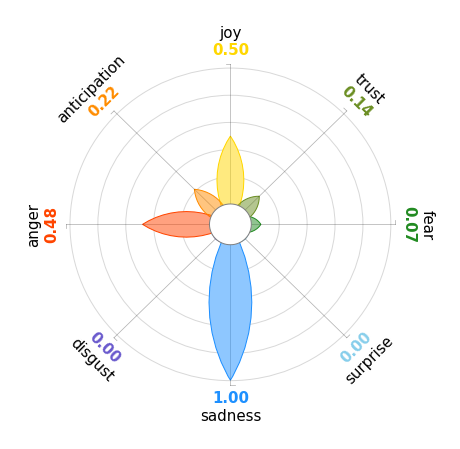

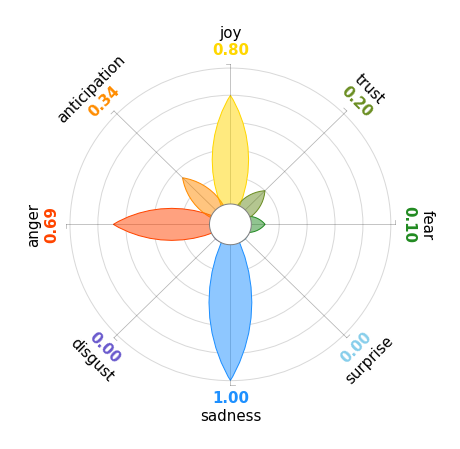

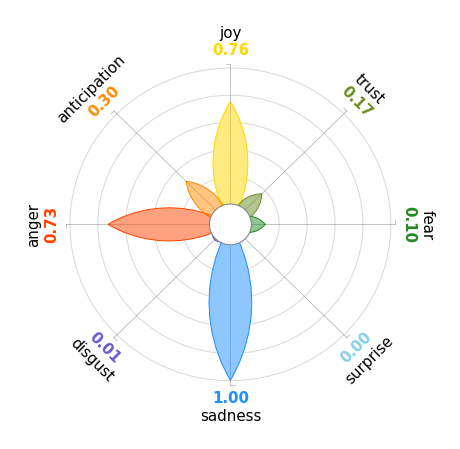

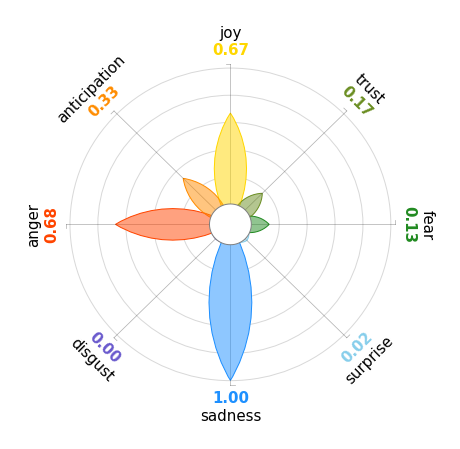

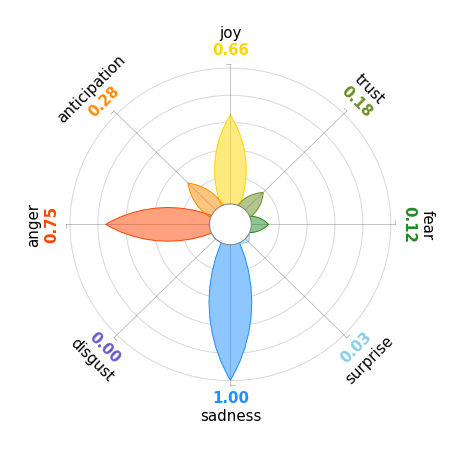

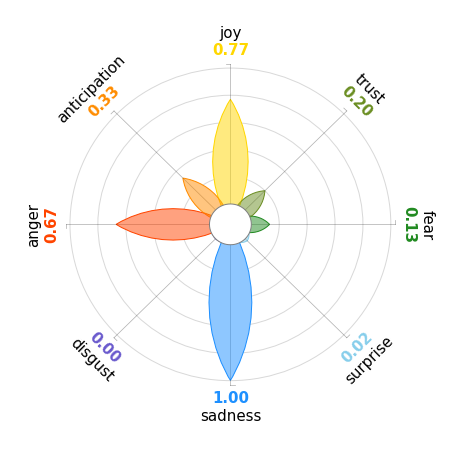

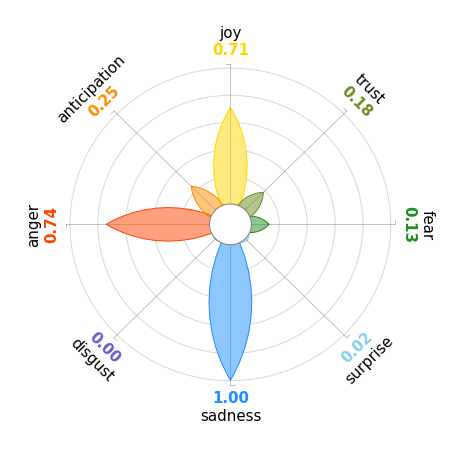

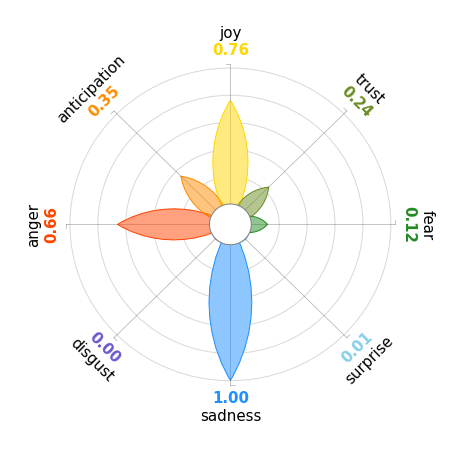

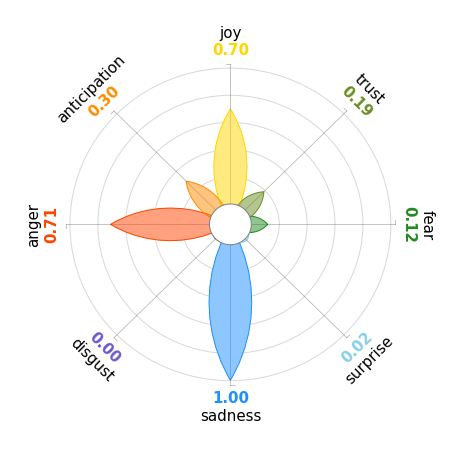

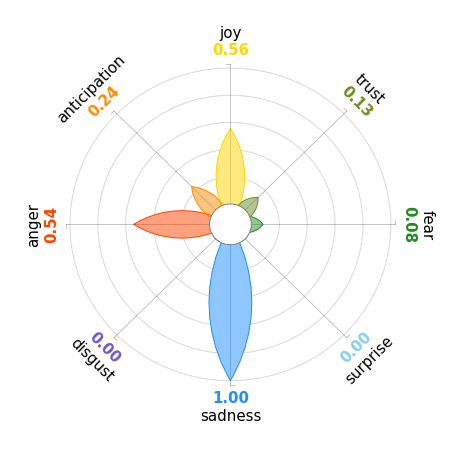

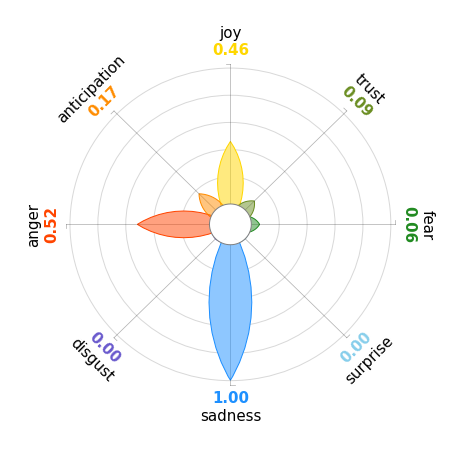

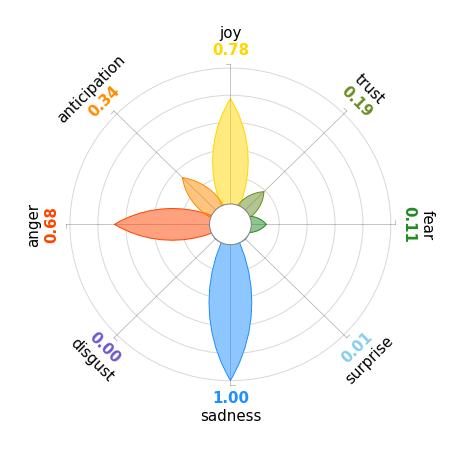

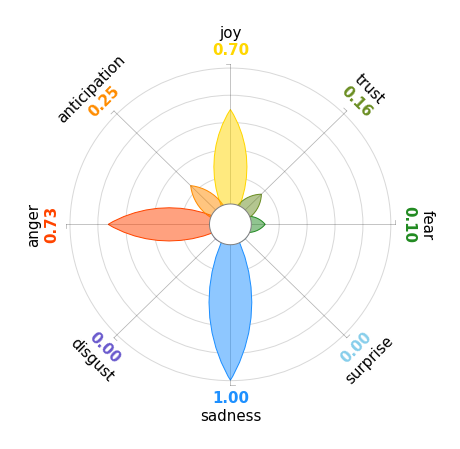

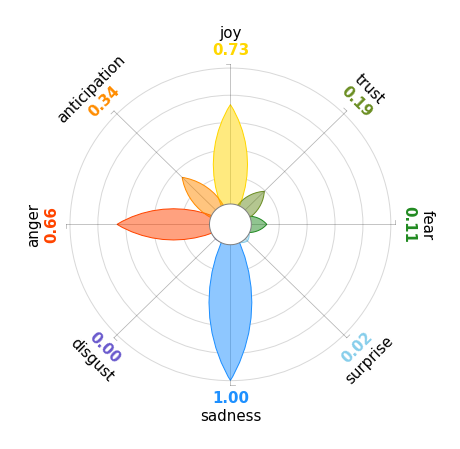

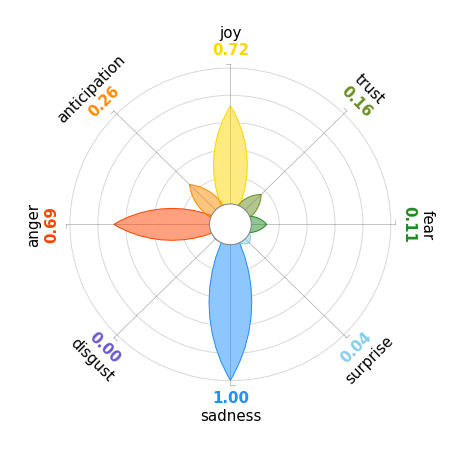

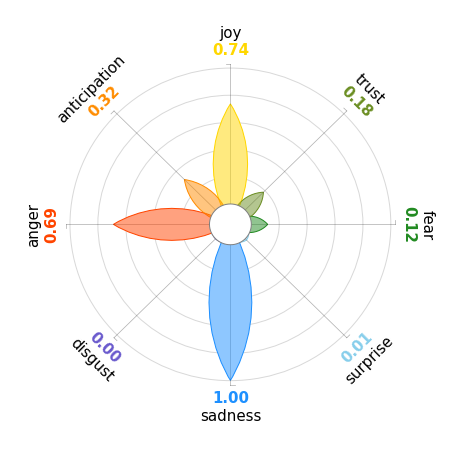

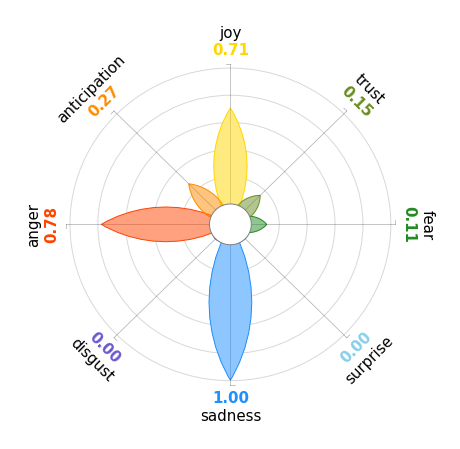

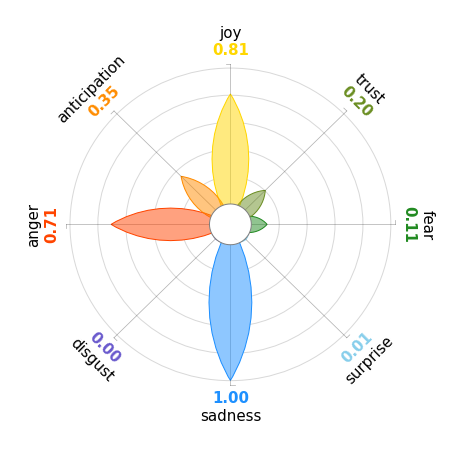

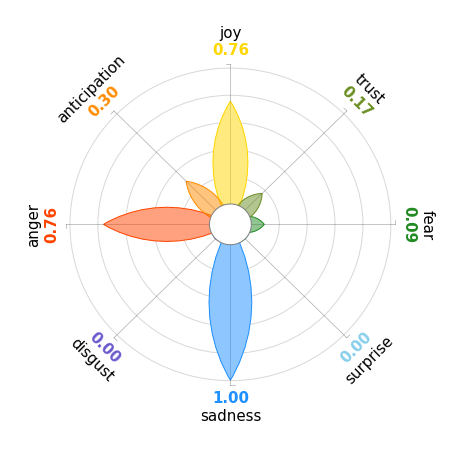

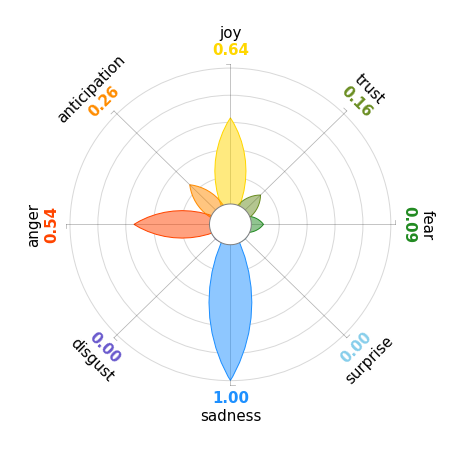

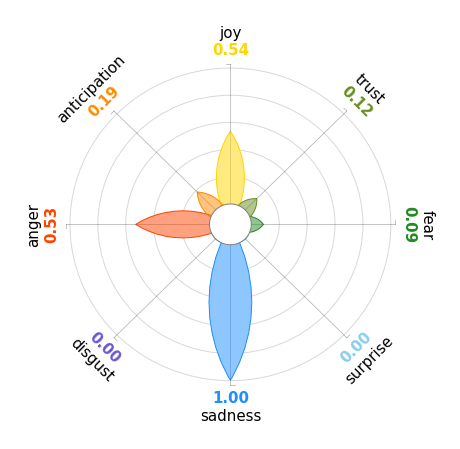

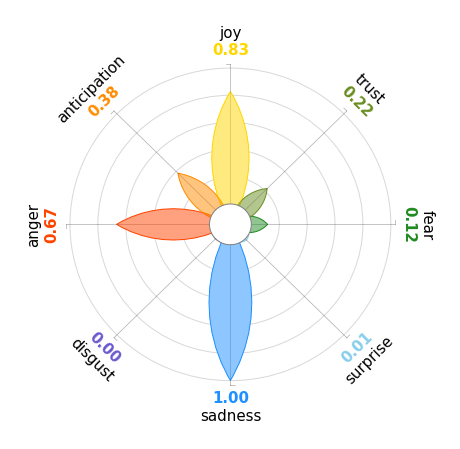

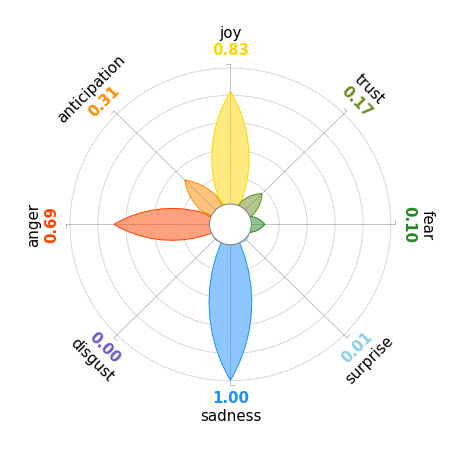

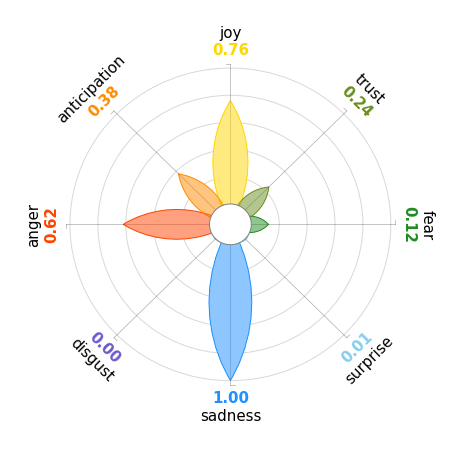

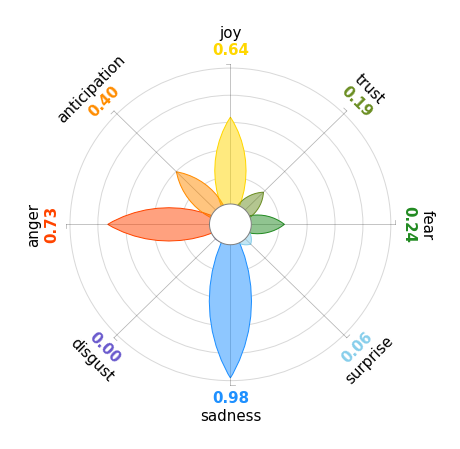

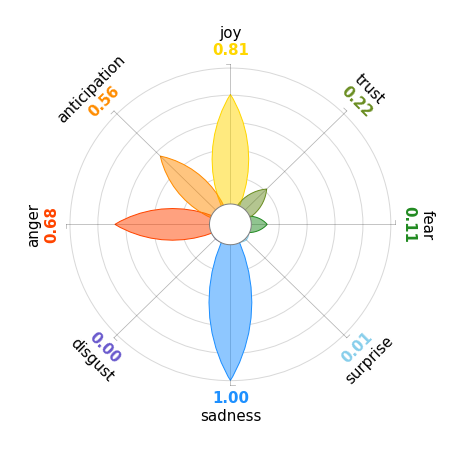

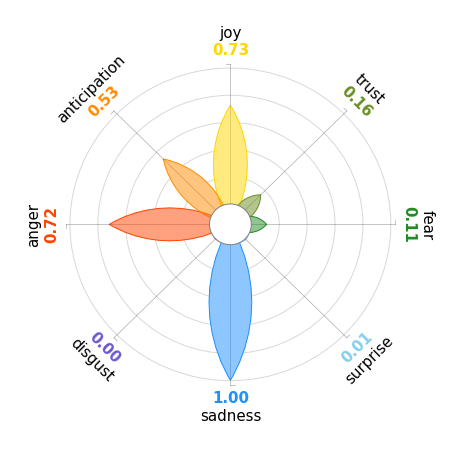

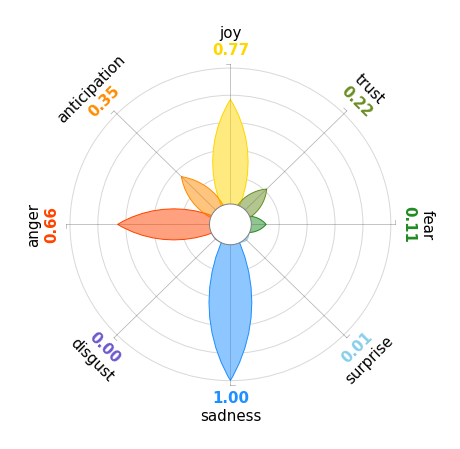

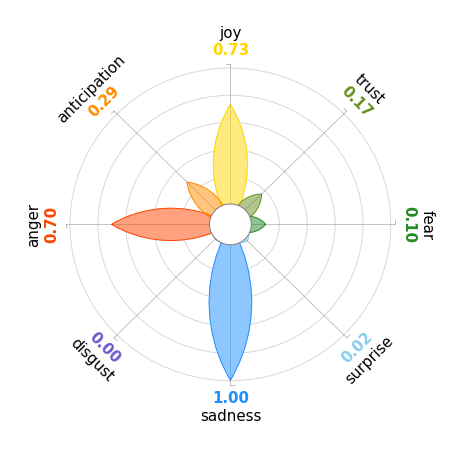

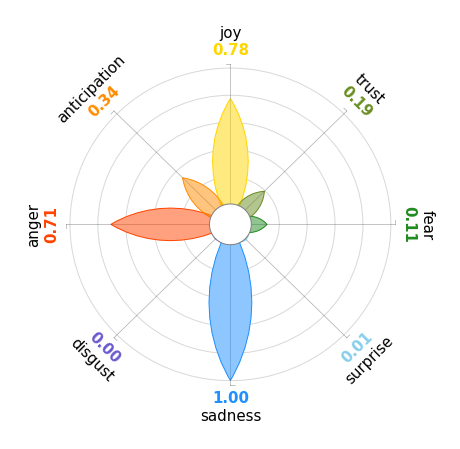

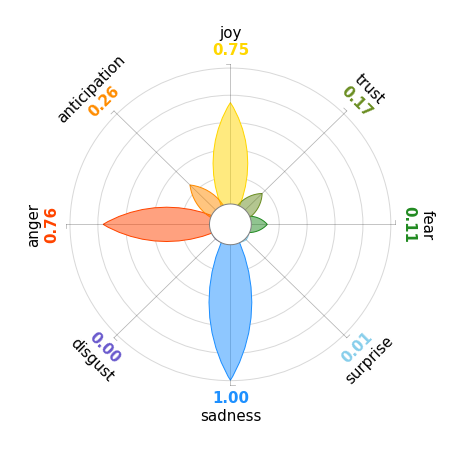

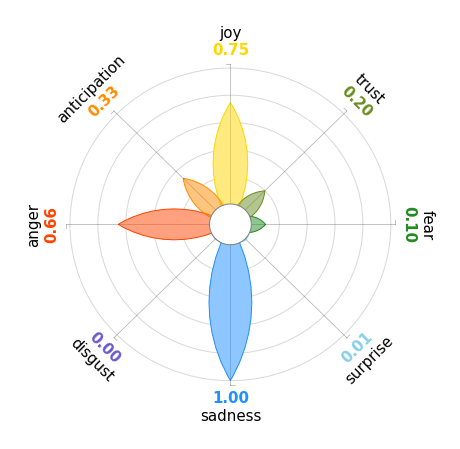

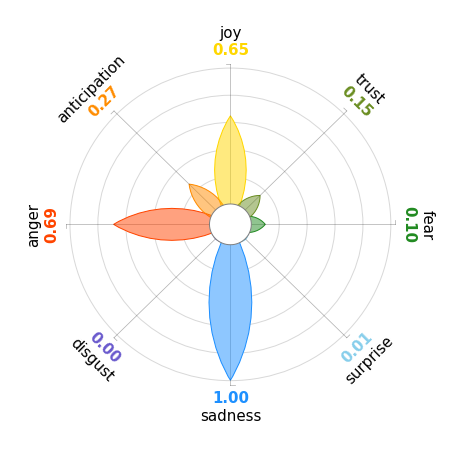

In [ ]:
import matplotlib.pyplot as plt

list(sorted_dict.values())[-20:]
list(sorted_dict.keys())[-40:]

for w in list(sorted_dict.keys())[-40:]:
  x = new_words_tfidf[w]
  y = new_words[w]

  #word_tf = (x)/(max(y)+1)
  #word = (y)/(max(y)+1)

  word_tf = (x-min(x))/(max(x)-min(x)+1)
  word = (y-min(y))/(max(y)-min(y)+1)

  emotions = {"fear": word[0], 	"anger": word[1], 	"sadness":word[2], 	"joy":word[3], 	"surprise":word[4], 	"disgust":word[5], 	"trust":word[6], 	"anticipation":word[7]}
  emotions_tf = {"fear": word_tf[0], 	"anger": word_tf[1], 	"sadness":word_tf[2], 	"joy":word_tf[3], 	"surprise":word_tf[4], 	"disgust":word_tf[5], 	"trust":word_tf[6], 	"anticipation":word_tf[7]}
  plutchik(emotions)
  plt.savefig(f'/content/drive/MyDrive/SentimentAnalysis/PlutchikPlots/{w}.png')
  plutchik(emotions_tf)
  plt.savefig(f'/content/drive/MyDrive/SentimentAnalysis/PlutchikPlots/{w}_TF.png')


## Cluster using the KMeans algorithm and visualise with PCA

In [ ]:
from sklearn.cluster import KMeans
clustering_dataframe = words_df.drop(["Word"], axis=1)
kmeans = KMeans(n_clusters=8, random_state=42).fit(clustering_dataframe)

In [ ]:
words_df["predictions"] = kmeans.predict(words_df.iloc[:, 1:])

Text(0.5, 1.0, 'PCA reduced data')

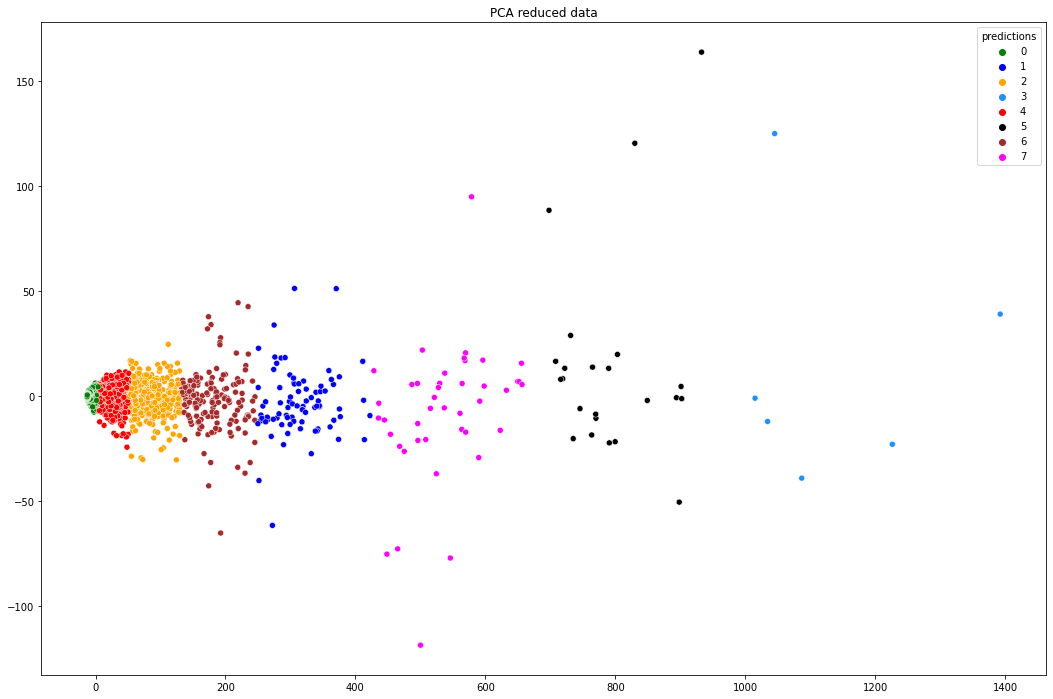

In [ ]:
from sklearn.decomposition import PCA
from  seaborn import scatterplot
import matplotlib.pyplot as plt


# we created the PCA object and fitted and transformed the data into 2 dimensions
pca = PCA(n_components=2)
col=words_df.iloc[:, 1:9]

sc= pca.fit_transform(col)
fig, ax = plt.subplots(figsize=(18, 12))
plot= scatterplot(x=[x[0] for x in sc],y=[x[1]for x in sc],hue=words_df["predictions"], palette=['green','blue','orange',"dodgerblue",'red', 'black', "brown", "magenta" ])
"""plot.set(xlim=(0, 10))

plot.set(ylim=(-2, 2))"""
plot.set_title('PCA reduced data')

## Cluster using the Agglomerative Clustering algorithm and visualise with PCA

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering_dataframe = words_df.drop(["Word", "predictions"], axis=1)
predictions = AgglomerativeClustering(n_clusters=8).fit(clustering_dataframe).labels_

Text(0.5, 1.0, 'PCA reduced data')

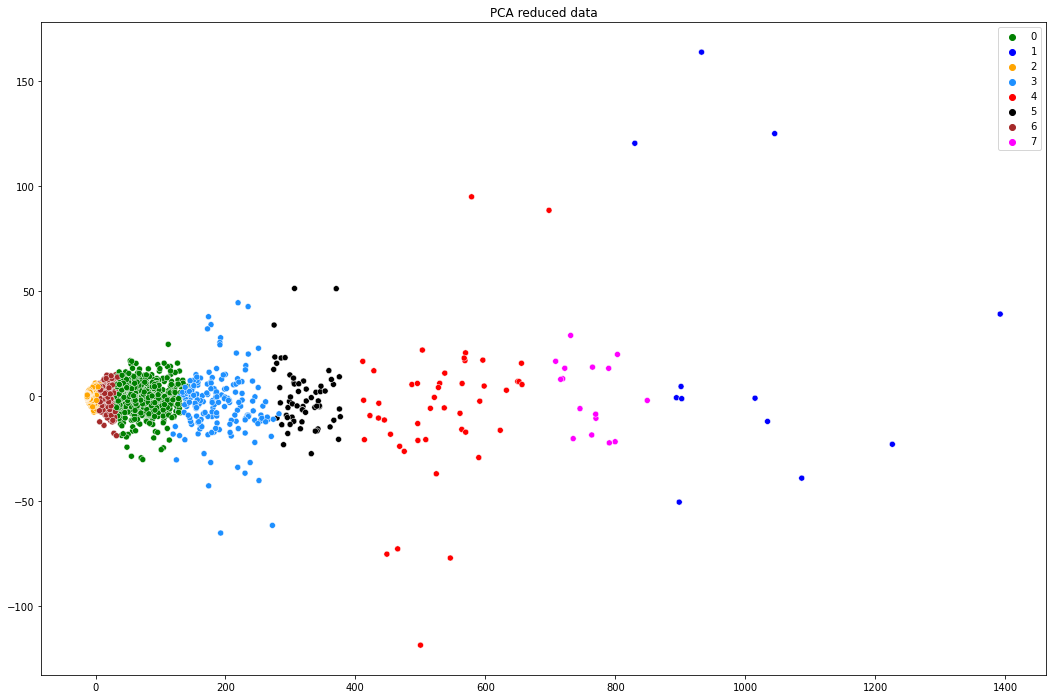

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))

plot= scatterplot(x=[x[0] for x in sc],y=[x[1]for x in sc],hue=predictions, palette=['green','blue','orange',"dodgerblue",'red', 'black', "brown", "magenta" ])
plot.set_title('PCA reduced data')

In [ ]:
pd.DataFrame({"Word":words_df["Word"], "KMeans_groups": words_df["predictions"], "Agglomerative_groups":predictions}).to_csv("/content/drive/MyDrive/SentimentAnalysis/word_groups.csv")